Select a company from the list below:
1. RELIANCE.NS
2. TCS.NS
3. HDFCBANK.NS
4. ICICIBANK.NS
5. INFY.NS
6. HINDUNILVR.NS
7. SBIN.NS
8. BHARTIARTL.NS
9. ITC.NS
10. LT.NS


Enter the number of your chosen company:  2
Enter the start date (YYYY-MM-DD):  2022-1-1
Enter the end date (YYYY-MM-DD):  2024-1-1


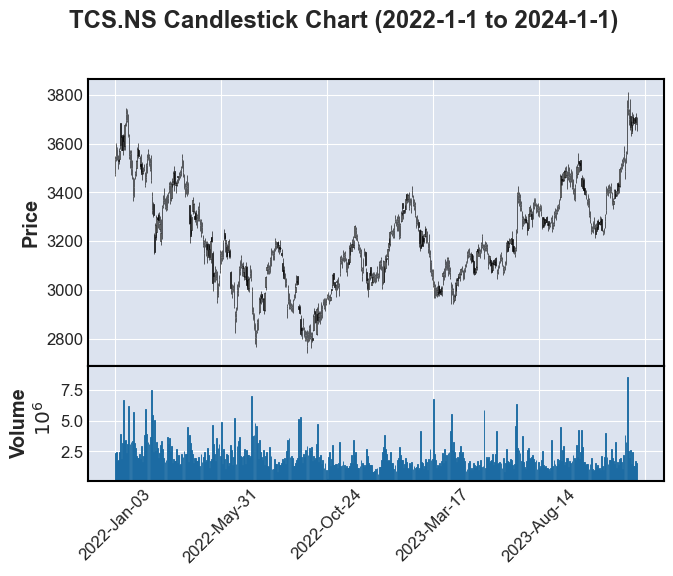

Epoch 1, Loss: 0.8817951679229736
Epoch 101, Loss: 0.0852307453751564
Epoch 201, Loss: 0.050845831632614136
Epoch 301, Loss: 0.04279670864343643
Epoch 401, Loss: 0.03703490272164345
Epoch 501, Loss: 0.03359397128224373
Epoch 601, Loss: 0.034354984760284424
Epoch 701, Loss: 0.02400069683790207
Epoch 801, Loss: 0.020672431215643883
Epoch 901, Loss: 0.02852221205830574


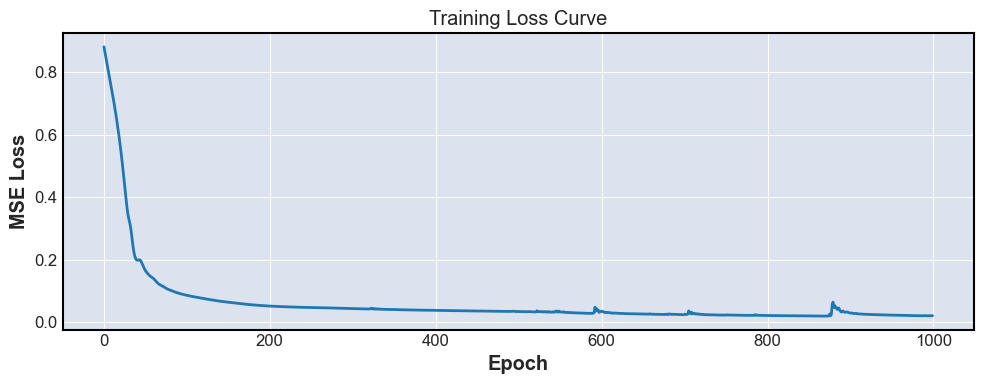


Evaluation Metrics:
MSE: 0.0194
MAE: 0.1044
RMSE: 0.1391
R² Score: 0.9778


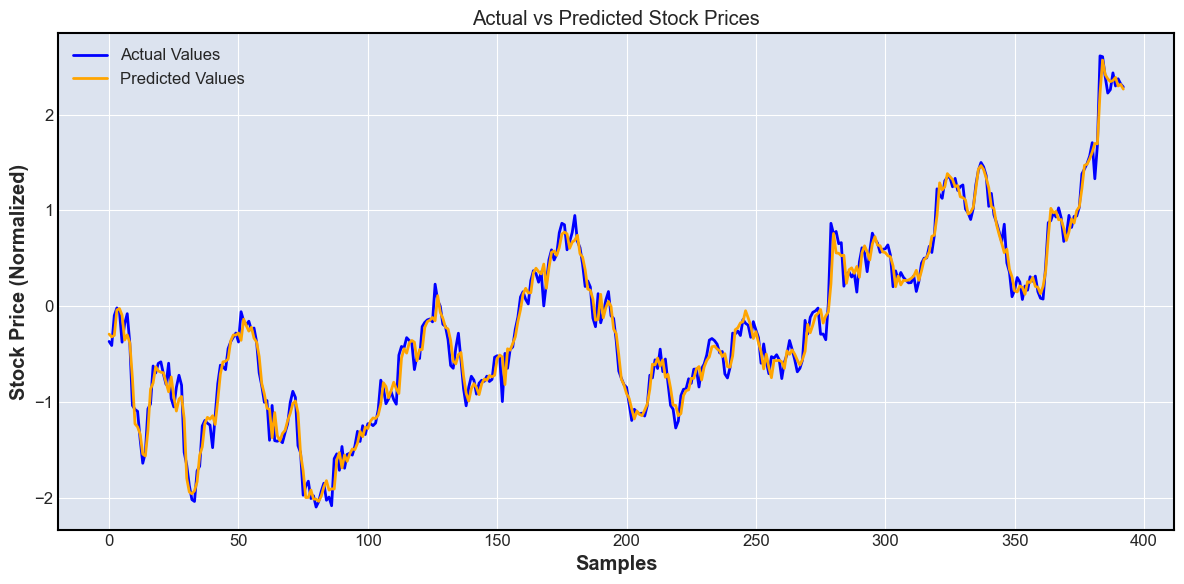

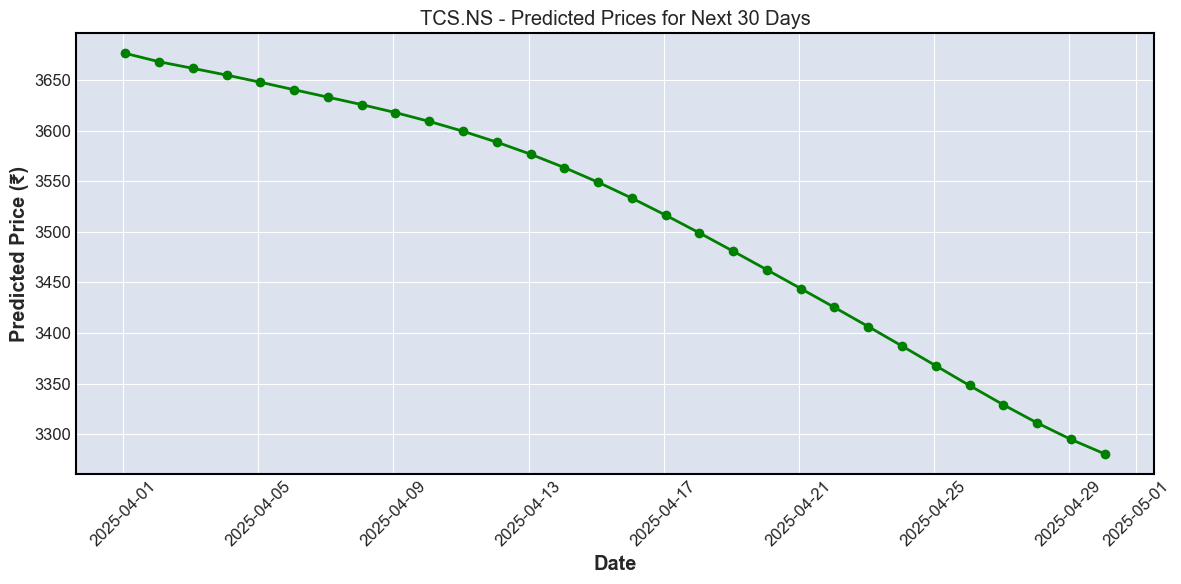

                         Date  Predicted Price
0  2025-04-01 01:25:37.981382      3676.258082
1  2025-04-02 01:25:37.981382      3668.000811
2  2025-04-03 01:25:37.981382      3661.466881
3  2025-04-04 01:25:37.981382      3654.804485
4  2025-04-05 01:25:37.981382      3647.736614
5  2025-04-06 01:25:37.981382      3640.347336
6  2025-04-07 01:25:37.981382      3633.007813
7  2025-04-08 01:25:37.981382      3625.654826
8  2025-04-09 01:25:37.981382      3617.776994
9  2025-04-10 01:25:37.981382      3609.070911
10 2025-04-11 01:25:37.981382      3599.377683
11 2025-04-12 01:25:37.981382      3588.607958
12 2025-04-13 01:25:37.981382      3576.692388
13 2025-04-14 01:25:37.981382      3563.493311
14 2025-04-15 01:25:37.981382      3549.007641
15 2025-04-16 01:25:37.981382      3533.280643
16 2025-04-17 01:25:37.981382      3516.507576
17 2025-04-18 01:25:37.981382      3498.955386
18 2025-04-19 01:25:37.981382      3480.896834
19 2025-04-20 01:25:37.981382      3462.553866
20 2025-04-21

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the companies
companies = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
             'HINDUNILVR.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'ITC.NS', 'LT.NS']

# Display company names for user selection
print("Select a company from the list below:")
for i, company in enumerate(companies):
    print(f"{i + 1}. {company}")

# Get user input for company selection
while True:
    choice = input("Enter the number of your chosen company: ")
    try:
        choice = int(choice)
        if 1 <= choice <= len(companies):
            selected_company = companies[choice - 1]
            break
        else:
            print("Invalid choice. Please enter a number within the range.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Get user input for start and end dates
while True:
    start_date_input = input("Enter the start date (YYYY-MM-DD): ")
    end_date_input = input("Enter the end date (YYYY-MM-DD): ")
    
    try:
        start_date = datetime.strptime(start_date_input, "%Y-%m-%d")
        end_date = datetime.strptime(end_date_input, "%Y-%m-%d")
        
        # Check if the duration is exactly 2 years
        if (end_date - start_date).days == 730:  # 2 years * 365 days
            break
        else:
            print("The duration must be exactly 2 years (730 days). Please try again.")
    except ValueError:
        print("Invalid date format. Please enter dates in YYYY-MM-DD format.")

# Load data for the selected company from user-defined dates
ticker = yf.Ticker(selected_company)
data = ticker.history(start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))

# Function to calculate indicators
def calculate_indicators(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
    return data

# Apply the function to calculate indicators
data = calculate_indicators(data)

# Display Candlestick Chart
mpf.plot(data, type='candle', title=f'{selected_company} Candlestick Chart ({start_date_input} to {end_date_input})',
         ylabel='Price', ylabel_lower='Volume', volume=True)

# Preprocess data for prediction
def preprocess_data(data):
    close_prices = pd.to_numeric(data['Close'], errors='coerce').dropna().values

    if len(close_prices) == 0:
        return None, None, None, None

    price_mean = close_prices.mean()
    price_std = close_prices.std()
    normalized_prices = (close_prices - price_mean) / price_std

    seq_len = 100
    sequences = []
    labels = []
    
    for i in range(len(normalized_prices) - seq_len):
        seq = normalized_prices[i:i + seq_len]
        label = normalized_prices[i + seq_len]
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor(labels, dtype=torch.float32)

    return sequences, labels, price_mean, price_std

# Apply function
sequences, labels, price_mean, price_std = preprocess_data(data)

if sequences is not None and labels is not None:
    
    # Define the LSTM Model
    class LSTMModel(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, 1)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out[:, -1])
            return output

    # Parameters for LSTM Model
    input_dim = 1
    hidden_dim = 50

    # Initialize model and optimizer
    model = LSTMModel(input_dim, hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop with loss tracking and visualization
    num_epochs = 1000 
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(sequences)
        loss = nn.MSELoss()(outputs.squeeze(), labels)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Plot training loss curve
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Predict future prices for the next 30 days
model.eval()
future_days = 30  # Number of days to predict
future_prices = []
last_sequence = sequences[-1].unsqueeze(0)  # Start with the last sequence from the training data

with torch.no_grad():
    for _ in range(future_days):
        output = model(last_sequence)
        future_prices.append(output.item())
        last_sequence = torch.cat((last_sequence[:, 1:], output.unsqueeze(-1)), dim=1)  # Update sequence with new prediction

# Denormalize future predictions
future_prices_denormed = (np.array(future_prices) * price_std) + price_mean

# Prepare dates for future predictions based on current date
last_date = datetime.now() + timedelta(days=1) 
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

# Create DataFrame for visualization or further analysis
predicted_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_prices_denormed})

# Evaluation Metrics: MSE, MAE, RMSE, R² Score
y_true = labels.numpy()
y_pred = model(sequences).detach().numpy().squeeze()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2_score_value = r2_score(y_true, y_pred)

print("\nEvaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2_score_value:.4f}")

# Plot Actual vs Predicted Graph
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_true)), y_true, label='Actual Values', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Samples')
plt.ylabel('Stock Price (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot future predictions for the next 30 days
plt.figure(figsize=(12, 6))
plt.plot(predicted_df['Date'], predicted_df['Predicted Price'], marker='o', linestyle='-', color='green')
plt.title(f'{selected_company} - Predicted Prices for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Price (₹)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print predicted prices DataFrame
print(predicted_df)
